# Pseudobulk analysis of TSS usage across donors using Whippet

In [21]:
.libPaths("/no_backup/jferrer/jmidgley/R_libs")
library(readr)
library(dplyr)
library(ggplot2)
library(tidyr)
library(showtext)
library(stringr)

In [2]:
font_add("Latin Modern Math", "../data_raw/fonts/LatinmodernmathRegular.otf")
showtext_auto()

In [3]:
combined_df <- read_tsv("../data_processed/curated_HIT.tsv", show_col_types = FALSE)
head(combined_df)

transcript_id,chr,exons,matched_to,category,unannotated_exons,Strand,summarized_category,ref_id,stripped_ref_id,⋯,relative_tx_exp,TSS_TPM_per_gene,Relative TSS usage,TSS_type,TSS_start,TSS_end,distance_to_closest_TSS,closest_TSS_ref_id,TSS distance category,TSS_name
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
ENCT00000006334.1,chr1,"[(61077274, 61077628), (61077916, 61079203)]","[(61077326, 61077628), (61077916, 61079231)]",GENCODE-annotated transcripts,NA,+,GENCODE-annotated transcripts,ENST00000699992.1,ENST00000699992,⋯,0.03697135,0.2137654,0.04434644,minor TSS,61077221,61077380,6,ENST00000699964.1,<=100bp,P3111_A
ENCT00000013056.1,chr1,"[(160261734, 160261922), (160281430, 160281892)]","[(160261682, 160261922), (160281430, 160281935)]",GENCODE-annotated transcripts,NA,+,GENCODE-annotated transcripts,ENST00000756371.1,ENST00000756371,⋯,0.48182098,0.7438744,1.00000000,unique TSS,160261726,160261763,0,ENST00000442130.1,<=100bp,P5604_A
ENCT00000019620.1,chr1,"[(239386568, 239387227), (239492709, 239492807), (239545641, 239545749), (239632224, 239632286), (239678186, 239678288), (239827252, 239827378), (239907433, 239915447)]","[(239386568, 239387227), (239492709, 239492807), (239545641, 239545749), (239632224, 239632286), (239678186, 239678288), (239827252, 239827378), (239907433, 239915450)]",GENCODE-annotated transcripts,NA,+,GENCODE-annotated transcripts,ENST00000676153.1,ENST00000676153,⋯,0.14990099,1.4214900,0.45456122,main TSS,239386576,239386587,8,ENST00000676153.1,<=100bp,P7900_A
ENCT00000022754.1,chr1,"[(23191893, 23195001), (23217291, 23217499)]","[(23191895, 23195001), (23217291, 23217502)]",GENCODE-annotated transcripts,NA,-,GENCODE-annotated transcripts,ENST00000374619.2,ENST00000374619,⋯,0.55372773,0.1167433,1.00000000,unique TSS,23217498,23217499,3,ENST00000374619.2,<=100bp,P1212_A
ENCT00000039204.1,chr1,"[(233319835, 233321155), (233327229, 233327357)]","[(233319834, 233321155), (233327229, 233327455)]",GENCODE-annotated transcripts,NA,-,GENCODE-annotated transcripts,ENST00000771587.1,ENST00000771587,⋯,0.26894786,2.0938848,0.91394776,main TSS,233327323,233327461,3,ENST00000771586.1,<=100bp,P7654_A
ENCT00000039480.1,chr1,"[(235826319, 235829036), (235830226, 235830424), (235833578, 235833667), (235866843, 235866903)]","[(235826364, 235829036), (235830226, 235830424), (235833578, 235833667), (235866843, 235866925)]",GENCODE-annotated transcripts,NA,-,GENCODE-annotated transcripts,ENST00000697183.1,ENST00000697183,⋯,0.13967604,6.2585203,0.93477391,main TSS,235866857,235866943,6,ENST00000389793.7,<=100bp,P7768_A


## Load gene TpM data

In [4]:
load_tpm_counts <- function(path, sample_name) {
  df <- read.table(gzfile(path), header = TRUE, sep = "\t")
  colnames(df)[colnames(df) == "TpM"] <- paste0(sample_name, "_TpM")
  colnames(df)[colnames(df) == "Read_Counts"] <- paste0(sample_name, "_Count")
  df[, c("Gene", paste0(sample_name, "_TpM"), paste0(sample_name, "_Count"))]
}

# Gene TPMs for Alpha cells
AFLO_alpha_gene_tpm <- load_tpm_counts("/no_backup/jferrer/jmidgley/whippet/RERUN/results/AFLO_merge_alpha.gene.tpm.gz", "AFLO")
BKEK_alpha_gene_tpm <- load_tpm_counts("/no_backup/jferrer/jmidgley/whippet/RERUN/results/BKEK_merge_alpha.gene.tpm.gz", "BKEK")
DBHQ_alpha_gene_tpm <- load_tpm_counts("/no_backup/jferrer/jmidgley/whippet/RERUN/results/DBHQ_merge_alpha.gene.tpm.gz", "DBHQ")
GPRL_alpha_gene_tpm <- load_tpm_counts("/no_backup/jferrer/jmidgley/whippet/RERUN/results/GPRL_merge_alpha.gene.tpm.gz", "GPRL")
HUEN_alpha_gene_tpm <- load_tpm_counts("/no_backup/jferrer/jmidgley/whippet/RERUN/results/HUEN_merge_alpha.gene.tpm.gz", "HUEN")

# Gene TPMs for Beta cells
AFLO_beta_gene_tpm <- load_tpm_counts("/no_backup/jferrer/jmidgley/whippet/RERUN/results/AFLO_merge_beta.gene.tpm.gz", "AFLO")
BKEK_beta_gene_tpm <- load_tpm_counts("/no_backup/jferrer/jmidgley/whippet/RERUN/results/BKEK_merge_beta.gene.tpm.gz", "BKEK")
DBHQ_beta_gene_tpm <- load_tpm_counts("/no_backup/jferrer/jmidgley/whippet/RERUN/results/DBHQ_merge_beta.gene.tpm.gz", "DBHQ")
GPRL_beta_gene_tpm <- load_tpm_counts("/no_backup/jferrer/jmidgley/whippet/RERUN/results/GPRL_merge_beta.gene.tpm.gz", "GPRL")
HUEN_beta_gene_tpm <- load_tpm_counts("/no_backup/jferrer/jmidgley/whippet/RERUN/results/HUEN_merge_beta.gene.tpm.gz", "HUEN")

# Merge alpha samples
gene_alpha_merged <- Reduce(function(x, y) merge(x, y, by = "Gene"), list(AFLO_alpha_gene_tpm, BKEK_alpha_gene_tpm, DBHQ_alpha_gene_tpm, GPRL_alpha_gene_tpm, HUEN_alpha_gene_tpm))
tpm_cols <- grep("_TpM$", colnames(gene_alpha_merged), value = TRUE)
gene_alpha_merged$Mean_TpM <- apply(gene_alpha_merged[, tpm_cols], 1, mean)

# Merge beta samples
gene_beta_merged <- Reduce(function(x, y) merge(x, y, by = "Gene"), list(AFLO_beta_gene_tpm, BKEK_beta_gene_tpm, DBHQ_beta_gene_tpm, GPRL_beta_gene_tpm, HUEN_beta_gene_tpm))                 
tpm_cols <- grep("_TpM$", colnames(gene_beta_merged), value = TRUE)
gene_beta_merged$Mean_TpM <- apply(gene_beta_merged[, tpm_cols], 1, mean)                         

In [5]:
combined_gene_summary <- merge(
  gene_alpha_merged[, c("Gene", "Mean_TpM")],
  gene_beta_merged[, c("Gene", "Mean_TpM")],
  by = "Gene",
  suffixes = c("_alpha", "_beta")
)

combined_gene_summary <- combined_gene_summary %>%
  left_join(
    combined_df %>%
      dplyr::select(gene_id = `Gene stable ID`, gene_name = `Gene name`) %>%
      distinct(gene_name, .keep_all = TRUE), 
    by = c("Gene" = "gene_id")
  )
head(combined_gene_summary)

,Gene,Mean_TpM_alpha,Mean_TpM_beta,gene_name
,<chr>,<dbl>,<dbl>,<chr>
1,ENSG00000000003,2.50,0.74,TSPAN6
2,ENSG00000000419,16.86,11.56,DPM1
3,ENSG00000000457,7.22,5.74,SCYL3
4,ENSG00000000460,2.80,2.48,FIRRM
5,ENSG00000000971,0.14,0.10,CFH
6,ENSG00000001036,41.66,22.48,FUCA2


In [6]:
combined_gene_summary %>% filter(gene_name == "IQSEC1")

Gene,Mean_TpM_alpha,Mean_TpM_beta,gene_name
<chr>,<dbl>,<dbl>,<chr>
ENSG00000144711,23.02,73.38,IQSEC1


## Load isoform TpM data

In [7]:
load_tpm_counts <- function(path, sample_name) {
  df <- read.table(gzfile(path), header = TRUE, sep = "\t", row.names=NULL)
  df <- df[1:(length(df)-1)]
  colnames(df) <- c("Isoform", "TpM", "Read_Counts")
  colnames(df)[colnames(df) == "TpM"] <- paste0(sample_name, "_TpM")
  colnames(df)[colnames(df) == "Read_Counts"] <- paste0(sample_name, "_Count")
  df[, c("Isoform", paste0(sample_name, "_TpM"), paste0(sample_name, "_Count"))]
}

# Isoform TPMs for Alpha cells
AFLO_alpha_isoform_tpm <- load_tpm_counts("../data_raw/whippet_isoform_quant/AFLO_merge_alpha.isoform.tpm.gz", "AFLO")
BKEK_alpha_isoform_tpm <- load_tpm_counts("../data_raw/whippet_isoform_quant/BKEK_merge_alpha.isoform.tpm.gz", "BKEK")
DBHQ_alpha_isoform_tpm <- load_tpm_counts("../data_raw/whippet_isoform_quant/DBHQ_merge_alpha.isoform.tpm.gz", "DBHQ")
GPRL_alpha_isoform_tpm <- load_tpm_counts("../data_raw/whippet_isoform_quant/GPRL_merge_alpha.isoform.tpm.gz", "GPRL")
HUEN_alpha_isoform_tpm <- load_tpm_counts("../data_raw/whippet_isoform_quant/HUEN_merge_alpha.isoform.tpm.gz", "HUEN")

# Isoform TPMs for Beta cells
AFLO_beta_isoform_tpm <- load_tpm_counts("../data_raw/whippet_isoform_quant/AFLO_merge_beta.isoform.tpm.gz", "AFLO")
BKEK_beta_isoform_tpm <- load_tpm_counts("../data_raw/whippet_isoform_quant/BKEK_merge_beta.isoform.tpm.gz", "BKEK")
DBHQ_beta_isoform_tpm <- load_tpm_counts("../data_raw/whippet_isoform_quant/DBHQ_merge_beta.isoform.tpm.gz", "DBHQ")
GPRL_beta_isoform_tpm <- load_tpm_counts("../data_raw/whippet_isoform_quant/GPRL_merge_beta.isoform.tpm.gz", "GPRL")
HUEN_beta_isoform_tpm <- load_tpm_counts("../data_raw/whippet_isoform_quant/HUEN_merge_beta.isoform.tpm.gz", "HUEN")

# Merge alpha samples
isoform_alpha_merged <- Reduce(function(x, y) merge(x, y, by = "Isoform"), list(AFLO_alpha_isoform_tpm, BKEK_alpha_isoform_tpm, DBHQ_alpha_isoform_tpm, GPRL_alpha_isoform_tpm, HUEN_alpha_isoform_tpm))
tpm_cols <- grep("_TpM$", colnames(isoform_alpha_merged), value = TRUE)
isoform_alpha_merged$Mean_TpM <- apply(isoform_alpha_merged[, tpm_cols], 1, mean)

# Merge beta samples
isoform_beta_merged <- Reduce(function(x, y) merge(x, y, by = "Isoform"), list(AFLO_beta_isoform_tpm, BKEK_beta_isoform_tpm, DBHQ_beta_isoform_tpm, GPRL_beta_isoform_tpm, HUEN_beta_isoform_tpm))
tpm_cols <- grep("_TpM$", colnames(isoform_beta_merged), value = TRUE)
isoform_beta_merged$Mean_TpM <- apply(isoform_beta_merged[, tpm_cols], 1, mean)

In [8]:
isoform_alpha_merged

Isoform,AFLO_TpM,AFLO_Count,BKEK_TpM,BKEK_Count,DBHQ_TpM,DBHQ_Count,GPRL_TpM,GPRL_Count,HUEN_TpM,HUEN_Count,Mean_TpM
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENCT00000000028.1,1.5,330.4408,2.1,272.3769,1.0,130.2293,1.1,227.5623,1.1,193.6381,1.36
ENCT00000000083.1,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.1,2.2633,0.1,2.4025,0.04
ENCT00000000203.1,1.5,117.4726,0.7,33.3933,1.0,44.8208,1.8,130.8131,1.7,107.7589,1.34
ENCT00000000219.1,0.1,1.0087,0.7,7.2630,0.7,6.2466,0.4,5.3462,0.3,3.5132,0.44
ENCT00000000269.1,1.0,116.9913,1.0,69.6921,1.3,93.7956,0.6,67.0236,0.6,57.7764,0.90
ENCT00000000276.1,3.2,454.3176,1.4,126.0000,1.1,90.0000,1.7,236.7150,0.7,81.0000,1.62
ENCT00000000288.1,1.5,186.9429,1.4,108.6555,2.3,177.5964,1.0,120.8977,0.8,88.8809,1.40
ENCT00000000299.1,0.3,32.9408,0.3,20.3207,0.3,21.7176,0.5,57.7441,0.3,27.8079,0.34
ENCT00000000337.1,0.1,0.2157,0.1,0.1298,0.0,0.0000,0.0,0.0000,0.3,1.0000,0.10


In [11]:
combined_isoform_summary <- merge(
  isoform_alpha_merged[, c("Isoform", "Mean_TpM")],
  isoform_beta_merged[, c("Isoform", "Mean_TpM")],
  by = "Isoform",
  suffixes = c("_alpha", "_beta")
)
head(combined_isoform_summary)

,Isoform,Mean_TpM_alpha,Mean_TpM_beta
,<chr>,<dbl>,<dbl>
1,ENCT00000000028.1,1.36,0.94
2,ENCT00000000083.1,0.04,2.90
3,ENCT00000000203.1,1.34,0.32
4,ENCT00000000219.1,0.44,0.28
5,ENCT00000000269.1,0.90,0.40
6,ENCT00000000276.1,1.62,1.16


In [12]:
nrow(combined_isoform_summary)

[1] 376342

In [22]:
# Load GTF file (for plotting exon tracks)
gtf_cols <- c("chr","source","feature","start","end","score","strand","frame","attribute")
HIT_gtf <- read_tsv("../data_processed/curated_HIT.gtf", show_col_types = FALSE, col_names = gtf_cols)


HIT_gtf <- HIT_gtf %>%
  mutate(
    gene_name = str_extract(attribute, 'gene_name "([^"]+)"') %>% 
                str_replace('gene_name "', '') %>% 
                str_replace('"', ''),

    transcript_id = str_extract(attribute, 'transcript_id "([^"]+)"') %>% 
                    str_replace('transcript_id "', '') %>% 
                    str_replace('"', '')
  )

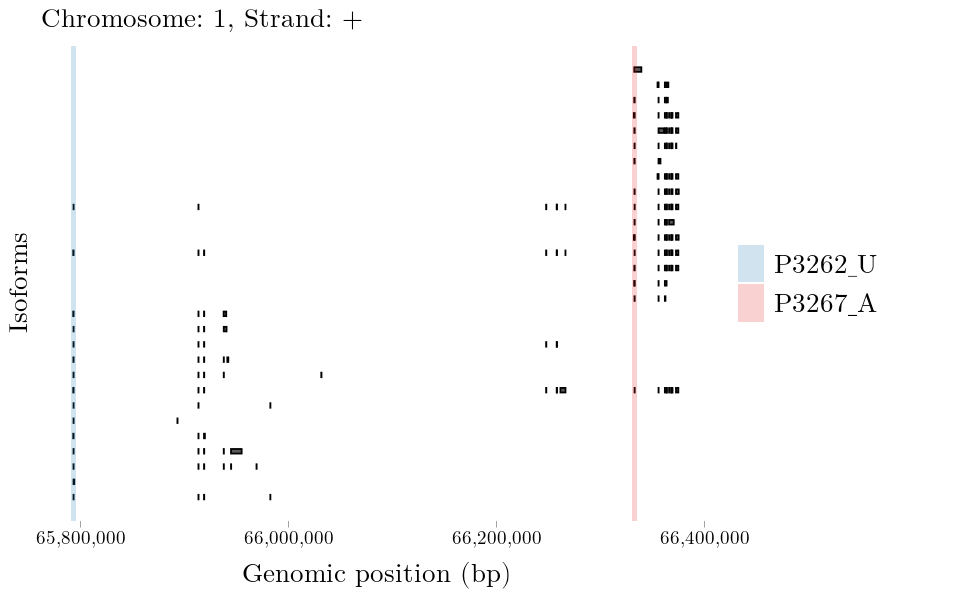

In [25]:
options(repr.plot.width = 8, repr.plot.height = 5)

selected_gene = "PDE4B"

# Get exon coordinates of transcripts
filtered_exon_df <- HIT_hg38 %>%
  dplyr::filter(gene_name == selected_gene, feature == "exon") %>%
  dplyr::select(transcript_id, start, end, strand, chromosome) %>%
  dplyr::arrange(transcript_id, start) 



# Only show isoforms that have a min expression amount
filtered_exon_df <- filtered_exon_df %>%
  filter(transcript_id %in% combined_isoform_summary$Isoform[combined_isoform_summary$Mean_TpM_alpha >= 0.0 | 
                                                       combined_isoform_summary$Mean_TpM_beta >= 0.0]) %>% 
    mutate( transcript_id = factor(transcript_id, levels = combined_isoform_summary %>% arrange(Mean_TpM_alpha) %>% pull(Isoform)))

filtered_exon_df$y <- as.numeric(factor(filtered_exon_df$transcript_id))

# Get TSS locations
tss_coords <- combined_df %>% dplyr::filter(`Gene name` == selected_gene, transcript_id %in% filtered_exon_df$transcript_id)  %>%
                              dplyr::select(TSS_name, TSS_start, TSS_end) %>%
                              dplyr::distinct() %>%
                              mutate(TSS_name = as.factor(TSS_name))
tss_coords$y <- 0 


# Combine exon and node plots
p <- ggplot() +
  # Transcripts
  geom_rect(
    data = filtered_exon_df,
    aes(xmin = start, xmax = end, ymin = y - 0.15, ymax = y + 0.15),
    color = "black"
  ) +
  # TSSs
  geom_rect(
    data = tss_coords %>% dplyr::filter(TSS_name %in% c("P3267_A", "P3262_U")),
    aes(xmin = TSS_start-2000, xmax = TSS_end+2000, ymin =-Inf, ymax = Inf, fill = TSS_name),
    alpha = 0.2
  ) +
  # Custom legend colors and labels
  scale_fill_manual(
    name = "TSS Group",
    values = c("P3262_U" = "#1f77b4",   # blue
               "P3267_A" = "#e41a1c")   # red
  ) +
  
  scale_y_continuous(breaks = NULL, labels = NULL) +
  scale_x_continuous(
    name = "Genomic position (bp)",
    labels = scales::comma,
    breaks = scales::breaks_pretty(n = 4)
  ) +
  
  labs(
    x = "",
    y = "Isoforms",
    title = paste0(
    "Chromosome: ", sub("^chr", "", filtered_exon_df$chromosome[1]),
    ", Strand: ", filtered_exon_df$strand[1])
  ) +
  theme_minimal() +
  theme(legend.position = "right",
    text = element_text(family = "Latin Modern Math"),
    legend.text = element_text(size = 20),
    legend.title = element_blank(),
    axis.title = element_text(size = 20),
    plot.title = element_text(size = 20),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_line(color = "black", linewidth = 0.1),
    axis.ticks.length.x = unit(4, "pt"),
    axis.text.x = element_text(size = 14, color = "black"))


p
ggsave("figures/PDE4B_isoforms_TSS.pdf", plot = p, width = 8, height = 5, dpi = 300)

In [27]:
# alpha
alpha_rel <- isoform_alpha_merged %>%
  left_join(combined_df %>% select(transcript_id, 
             gene_id = `Gene stable ID`, 
             gene_name = `Gene name`,
            TSS_name),
    by = c("Isoform" = "transcript_id")) %>%
  pivot_longer(
    cols = ends_with("_TpM"),
    names_to = "donor",
    values_to = "TpM"
  ) %>%
  group_by(gene_name, gene_id, donor) %>%
  mutate(sum_gene_TpM = sum(TpM, na.rm = TRUE)) %>%       # total per gene per donor
  group_by(gene_name, gene_id, TSS_name, donor) %>%
  summarise(
    total_TpM = sum(TpM, na.rm = TRUE),
    rel_usage = if_else(sum_gene_TpM > 0, total_TpM / sum_gene_TpM, 0),
    .groups = "drop_last"
  ) %>%
  summarise(
    Mean_rel_alpha = mean(rel_usage, na.rm = TRUE),
    SD_rel_alpha   = sd(rel_usage, na.rm = TRUE),
    .groups = "drop"
  )


# beta
beta_rel <- isoform_beta_merged %>%
  left_join(combined_df %>% select(transcript_id, 
             gene_id = `Gene stable ID`, 
             gene_name = `Gene name`,
            TSS_name),
    by = c("Isoform" = "transcript_id")) %>%
  pivot_longer(
    cols = ends_with("_TpM"),
    names_to = "donor",
    values_to = "TpM"
  ) %>%
  group_by(gene_name, gene_id, donor) %>%
  mutate(sum_gene_TpM = sum(TpM, na.rm = TRUE)) %>%
  group_by(gene_name, gene_id, TSS_name, donor) %>%
  summarise(
    total_TpM = sum(TpM, na.rm = TRUE),
    rel_usage = if_else(sum_gene_TpM > 0, total_TpM / sum_gene_TpM, 0),
    .groups = "drop_last"
  ) %>%
  summarise(
    Mean_rel_beta = mean(rel_usage, na.rm = TRUE),
    SD_rel_beta   = sd(rel_usage, na.rm = TRUE),
    .groups = "drop"
  )

# Combine
TSS_expression <- full_join(alpha_rel, beta_rel,
                            by = c("gene_name", "gene_id", "TSS_name"))

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”


In [28]:
TSS_expression[TSS_expression$gene_name == "PDE4B", ]

gene_name,gene_id,TSS_name,Mean_rel_alpha,SD_rel_alpha,Mean_rel_beta,SD_rel_beta
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
PDE4B,ENSG00000184588,P3260_A,0.06941591,0.03907206,0.09314394,0.04880256
PDE4B,ENSG00000184588,P3261_U,0.00000000,0.00000000,0.11103531,0.05197359
PDE4B,ENSG00000184588,P3262_U,0.07889563,0.03780215,0.61878226,0.15786214
PDE4B,ENSG00000184588,P3266_U,0.11824100,0.01758350,0.02300332,0.01151340
PDE4B,ENSG00000184588,P3267_A,0.60096483,0.13917585,0.13522286,0.09362415
PDE4B,ENSG00000184588,P3269_U,0.13248262,0.08112446,0.01881230,0.01447107


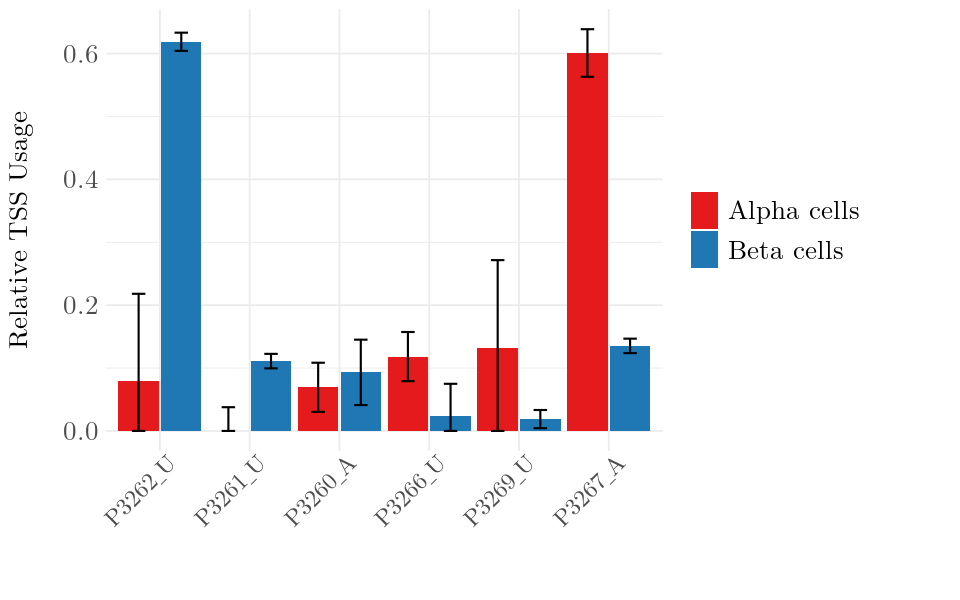

In [29]:
plot_df <- TSS_expression[TSS_expression$gene_name == "PDE4B", ]

plot_long <- pivot_longer(plot_df,
                          cols = c(Mean_rel_alpha, Mean_rel_beta),
                          names_to = "cell_type",
                          values_to = "ratio")

plot_long$sd <- ifelse(
  plot_long$cell_type == "Mean_rel_alpha",
  plot_df$SD_rel_alpha,
  plot_df$SD_rel_beta
)

plot_long <- plot_long %>%
  mutate(TSS_name = factor(
    TSS_name,
    levels = plot_df$TSS_name[order(plot_df$Mean_rel_beta - plot_df$Mean_rel_alpha,
                                    decreasing = TRUE)]
  ))


# Create grouped bar plot
p <- ggplot(plot_long, aes(x = TSS_name, y = ratio, fill = cell_type)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.95)) +
  geom_errorbar(
    aes(
      ymin = pmax(0, ratio - sd),
      ymax = ratio + sd
    ),
    position = position_dodge(width = 0.95),
    width = 0.3,
    color = "black",
    linewidth = 0.6
  ) +
  theme_minimal() +
  labs(x = "TSS Group", y = "Relative TSS Usage", fill = NULL) +
  scale_fill_manual(
    values = c("Mean_rel_alpha" = "#e41a1c",   # blue for alpha
               "Mean_rel_beta"  = "#1f77b4"),  # red for beta
    labels = c("Alpha cells", "Beta cells")  # change legend text
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 0.9, size=18),
    text = element_text(family = "Latin Modern Math"),
    axis.text.y  = element_text(size = 20),
    axis.title.x = element_blank(),
    axis.title.y = element_text(size = 20),
    legend.text  = element_text(size = 20))

p
ggsave("figures/PDE4B_usage.pdf", plot = p, width = 8, height = 5, dpi = 300)